# Dafalis and Manzari Model

The Dafalias and Manzari model is a stress-ratio controlled, critical state compatible bounding surface plasticity model for sand. 

Dafalias Y.F., and Manzari, M.T. (2004). "Simple plasticity sand model accounting for fabric change effects." J. Eng. Mech., 130(6) https://doi.org/10.1061/(ASCE)0733-9399(2004)130:6(622)
  


## Yield Surface

$f = \left|\eta - \alpha\right| - m$  

$\eta = \frac{q}{p}$  

$\alpha$ = back-stress ratio  

$m$ = yield stress ratio

## Elasticity

$\dot{q} = 3G\dot{\varepsilon_q^e}$  

$\dot{p} = K\dot{\varepsilon_v^e}$  

$G = G_0p_a\frac{\left(2.97-e\right)^2}{1+e}\left(\frac{p}{p_a}\right)^{1/2}$  

$G_0$ = constant 

$K = \frac{2\left(1+\nu\right)}{3\left(1-2\nu\right)}G$  

## Flow Rule

$\dot{\eta} = H\dot{\varepsilon_q^p}$  

$\dot{\varepsilon_v^p} = d\left|\dot{\varepsilon_q^p}\right|$  

$d = A_d\left(M^d - \eta\right)$  = dilatancy

$dz = -c_z\left<-\dot{\varepsilon_v^p}\right>\left(s\cdot z_{max} + z\right)$  

$A_d = A_0\left(1+\left<sz\right>\right)$  

$M^d = M exp\left(n^d\psi\right)$  = dilation surface

$\psi = e - e_c$  

$e_c = e_0 - \lambda_c\left(p/p_a\right)^\xi$  


MacCaulay brackets $\left< \right>$ operate according to $\left<x\right> = x$ if $x>0$ and $\left<x\right> =0$ if $x \leq 0$  

$s = \pm 1$ according to $\eta = \alpha \pm m$ (i.e., $s=+1$ if $\dot{\eta}>0$ and $s=-1$ if $\dot{\eta}<0$).

## Hardening

$H = h\left(M^b - \eta\right)$  

$h = \frac{b_0}{\left|\eta-\eta_{in}\right|}$  

$b_0 = G_0h_0\left(1-c_he\right)\left(\frac{p}{p_a}\right)^{-1/2}$  

$M^b = M exp\left(-n^b\psi\right)$ = bounding surface stress ratio  



In [1]:
%%html
<style>
table {float:left}
</style>

## Model Constants  

A set of default material constants was provided in the paper, as summarized below.

| Constant   | Variable | Default Value |  
|------------|----------|---------------|
| Elasticity | $G_0$    | 125           |
|            | $\nu$    | 0.05          |
| Critical State | $M$ | 1.25 |  
| | $c$ | 0.712 |
| | $\lambda_c$ | 0.019|
| | $e_0$ | 0.934 |
| | $\xi$ | 0.7 |
| Yield Surface | $m$| 0.01 |
| Plastic Modulus | $h_0$ | 7.05 |
| | $c_h$ | 0.968 |
| | $n^b$ | 1.1 |
| Dilatancy | $A_0$ | 0.704 |
| | $n^d$ | 3.5 | 
| Fabric-Dilatancy Tensor | $z_{max}$ | 4 |
| | $c_z$ | 600 |








# Explicit Integration Solution

Implicit integration is very difficult for this model, so we will use explicit integration instead. This means we will use the values of internal variables at the start of the current increment to compute their values at the end of the increment. Explicit procedures are numerically unstable, and require very small strain increments to produce a solution. Also, we will assume the elastic properties are constant for the strain increment to simplify the solution.

The solution may be simplified by making a few adjustments to the yield function. 

$f = \left|\frac{q}{p} - \alpha\right| - m$  

Multiply by sign function to get rid of absolute values

$f = \left(\frac{q}{p} - \alpha\right)s - m$  

where $s = sign\left(\frac{q}{p} - \alpha\right) = sign\left(q - p\alpha\right)$  

Multiply by p.

$f\cdot p = \left(q - \alpha p\right)s - mp$  

Since $f = 0$, and $p$ is positive, we can drop the $p$ from the left side

$f = \left(q - \alpha p\right)s - mp$  

$f = qs - p\left(\alpha s + m\right)$  

Now implement solution to solve for $\Delta\gamma$  

$q^{trial} = q_i + 3G\dot{\varepsilon}_q$  
$p^{trial} = p_i + K\dot{\varepsilon}_v$  
$\alpha^{trial} = \alpha_i$  
$f_{trial} = q^{trial}s - p^{trial}\left(\alpha^{trial}s + m\right)$  

$if\left(f_{trial} \le 0\right)$  

>$q_{i+1} = q^{trial}$  
>$p_{i+1} = p^{trial}$  
>$\alpha_{i+1} = \alpha^{trial}$  

$else$  

>$\dot{\varepsilon}_q^p = \Delta\gamma\frac{\partial f}{\partial q} = \Delta\gamma s$  
>$q_{i+1} = q_i + 3G_i\left(\dot{\varepsilon}_q - \dot{\varepsilon}_q^p\right) = q^{trial} -3G_i\Delta\gamma s$  
>$p_{i+1} = p_i + K_i\left(\dot{\varepsilon}_v - \dot{\varepsilon}_v^p\right) = p^{trial} -K_id\left|\Delta\gamma s\right|$   
>$\alpha_{i+1} = \alpha_i + H_i\dot{\varepsilon}_q^p = \alpha^{trial} + H_i\Delta\gamma s$  
>$f = 0 = \left(q^{trial} -3G_i\Delta\gamma s\right)s - \left(p^{trial} -K_id\left|\Delta\gamma s\right|\right)\left(\left(\alpha^{trial} + H_i\Delta\gamma s\right)s + m\right)$  

>Note that the direction of $\dot{\varepsilon}_q^p$ must be the same as the loading direction, $s$. Therefore $\left|\Delta\gamma s\right| = \Delta\gamma s$. Also $s^2 = 1$    
>$f = 0 = q^{trial}s -3G_i\Delta\gamma - \left(p^{trial} -K_id\Delta\gamma s\right)\left(\alpha^{trial}s + H_i\Delta\gamma +m\right)$  

>Expanding  
>$f = 0 = q^{trial}s - p^{trial}\left(\alpha^{trial}s + m\right) -3G_i\Delta\gamma - p^{trial}H_i\Delta\gamma +K_id\Delta\gamma\alpha^{trial} + K_idsH_i\Delta\gamma^2 + K_idms\Delta\gamma$    

> Collecting terms, we obtain the following quadratic expression for $\Delta\gamma$  
>$f = 0 = f^{trial} + \Delta\gamma\left[K_id\left(\alpha^{trial} + ms\right) -3G_i - p^{trial}H_i \right] + \Delta\gamma^2K_idsH_i$  

>Solving for the physically meaningful root  
>$\Delta\gamma = \frac{-b - \sqrt{b^2 - 4ac}}{2a}$  

>Where  
> $a = K_idsH_i$  
> $b = K_id\left(\alpha^{trial} + ms\right) -3G_i - p^{trial}H_i$  
> $c = f^{trial}$  

> And then update internal variables  
> $q_{i+1} = q^{trial} -3G_i\Delta\gamma$  
> $p_{i+1} = p^{trial} -K_id\left|\Delta\gamma\right|$  
> $\eta_{i+1} = \frac{q_{i+1}}{p_{i+1}}$  
> $\alpha_{i+1} = \alpha_i + H\Delta\gamma$  (note, H = infinity for the first step in current plastic loading cycle, in which case $\alpha_{i+1} = \alpha_i$)  
> $\eta_{in} = \alpha_i + ms$ (if plastic loading direction is new)  
> $b_0 = G_0h_0\left(1-c_he\right)\left(\frac{p_{i+1}}{p_a}\right)^{-0.5}$  
> $h = \frac{b_0}{\left|\eta_{i+1} - \eta_{in}\right|}$  (note, if $\eta_{i+1} = \eta_{in}$, h = infinity. must catch this runtime error)  
> $\psi = e - \left(e_0 - \lambda_c\left(\frac{p_{i+1}}{p_a}\right)^\xi\right)$  
> $M^b = Mexp\left(-n^b\psi\right)$  
> $M^d = Mexp\left(n^d\psi\right)$  
> $H = h\left(M^b-s\eta_{i+1}\right)$  
> $dz = -c_z\left<-\Delta\gamma\right>\left(sz_{max} + z\right)$  
> $A_d = A_0\left(1+\left<sz\right>\right)$  
> $d = A_d\left(M^d - s\eta_{i+1}\right)$  
> $e = e - \varepsilon_v\left(1+e\right)$  

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
def dafalias_manzari_strain_control(G0,nu,M,c,lambda_c,e0,e,xi,m,h0,ch,nb,A0,nd,zmax,cz,pa,z,p0,q0,epsilon_q,epsilon_v):
    N = len(epsilon_q)
    # Initialize arrays to 0
    p = np.zeros(N)
    q = np.zeros(N)
    p[0] = p0
    q[0] = q0
    G = G0*pa*(2.97-e)**2/(1+e)*(p[0]/pa)**0.5
    K = 2*(1+nu)/(3*(1-2*nu))
    E = 2*(1+nu)*G
    eta = q[0]/p[0]
    depsilon_qp = 0.0
    depsilon_vp = 0.0
    eta_in = m*np.sign(epsilon_q[1] - epsilon_q[0])
    alpha = 0.0
    SIGN = 0
    d = 0
    H = math.inf
    for i in range(1,N,1):
        depsilon_q = epsilon_q[i] - epsilon_q[i-1]
        depsilon_v = epsilon_v[i] - epsilon_v[i-1]
        G = G0*pa*(2.97-e)**2/(1+e)*(p[i-1]/pa)**0.5
        K = 2*(1+nu)/(3*(1-2*nu))*G
        q_trial = q[i-1] + 3*G*depsilon_q
        p_trial = p[i-1] + K*depsilon_v
        alpha_trial = alpha
        s = np.sign(q_trial - p_trial*alpha_trial)
        f_trial = q_trial*s - p_trial*(alpha_trial*s + m)
        if(f_trial<0):
            depsilon_qp = 0.0
            depsilon_vp = 0.0
            p[i] = p_trial
            q[i] = q_trial
            H = math.inf
        else:
            if(H == math.inf):
                dgamma = 0.0
            else:
                a = K*d*s*H
                b = K*d*(alpha_trial + m*s) - H*p_trial - 3*G
                c = f_trial
                dgamma = (-b - np.sqrt(b**2-4*a*c))/(2*a)
            depsilon_qp = dgamma*s
            depsilon_vp = d*np.abs(depsilon_qp)
            p[i] = p[i-1] + K*(depsilon_v - depsilon_vp)
            q[i] = q[i-1] + 3*G*(depsilon_q - depsilon_qp)
            
            eta = q[i]/p[i]
            if(s != SIGN):
                eta_in = alpha + m*s
                SIGN = s
            b0 = G0*h0*(1-ch*e)*(p[i]/pa)**-0.5
            if(eta==eta_in):
                depsilon_qp = 0.0
                depsilon_vp = 0.0
                continue
            h = b0/np.abs(eta-eta_in)
            psi = e - (e0 - lambda_c*(p[i]/pa)**xi)
            Mb = M*np.exp(-nb*psi)
            Md = M*np.exp(nd*psi)
            H = h*(Mb - eta*s)       
            alpha = alpha + H*depsilon_qp
            if(-depsilon_vp>0):
                dz = cz*depsilon_vp*(s*zmax + z)
            else:
                dz = 0
            z = z+dz
            if(s*z>0):
                Ad = A0*(1+s*z)
            else:
                Ad = A0
            d = Ad*(Md - eta*s)
        e = e - depsilon_v*(1+e)
    return([q,p])

# Reproduce Figure 5

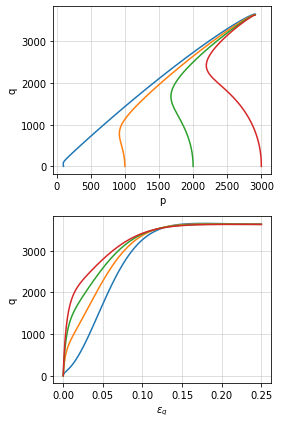

In [4]:
G0 = 125
nu = 0.05
M = 1.25
c = 0.712
lambda_c = 0.019
e0 = 0.934
e = 0.735
xi = 0.7
m = 0.01
h0 = 7.05
ch = 0.968
nb = 1.1
A0 = 0.704
nd = 3.5
zmax = 4.0
cz = 600
pa = 101.325
z = 0.0
p0 = [100, 1000, 2000, 3000]
q0 = [0, 0, 0, 0]
N = 10000
epsilon_q = np.linspace(0,0.25,N)
epsilon_v = np.zeros(N)
q = []
p = []
for i in range(len(p0)):
    q_temp, p_temp = dafalias_manzari_strain_control(G0,nu,M,c,lambda_c,e0,e,xi,m,h0,ch,nb,A0,nd,zmax,cz,pa,z,p0[i],q0[i],epsilon_q,epsilon_v)
    q.append(q_temp)
    p.append(p_temp)
    
fig, ax = plt.subplots(nrows=2,figsize=(4,6))
for i in range(len(p0)):
    ax[0].plot(p[i],q[i])
    ax[1].plot(epsilon_q,q[i])
ax[0].grid(True,alpha=0.5)
ax[1].grid(True,alpha=0.5)
ax[0].set_xlabel('p')
ax[0].set_ylabel('q')
ax[1].set_xlabel(r'$\varepsilon_q$')
ax[1].set_ylabel('q')
plt.tight_layout()

# Reproduce Figure 6

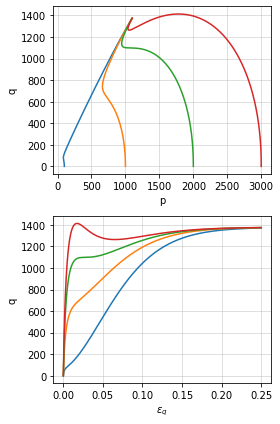

In [5]:
G0 = 125
nu = 0.05
M = 1.25
c = 0.712
lambda_c = 0.019
e0 = 0.934
e = 0.833
xi = 0.7
m = 0.01
h0 = 7.05
ch = 0.968
nb = 1.1
A0 = 0.704
nd = 3.5
zmax = 4.0
cz = 600
pa = 101.325
z = 0.0
p0 = [100, 1000, 2000, 3000]
q0 = [0, 0, 0, 0]
N = 10000
epsilon_q = np.linspace(0,0.25,N)
epsilon_v = np.zeros(N)
q = []
p = []
for i in range(len(p0)):
    q_temp, p_temp = dafalias_manzari_strain_control(G0,nu,M,c,lambda_c,e0,e,xi,m,h0,ch,nb,A0,nd,zmax,cz,pa,z,p0[i],q0[i],epsilon_q,epsilon_v)
    q.append(q_temp)
    p.append(p_temp)
    
fig, ax = plt.subplots(nrows=2,figsize=(4,6))
for i in range(len(p0)):
    ax[0].plot(p[i],q[i])
    ax[1].plot(epsilon_q,q[i])
ax[0].grid(True,alpha=0.5)
ax[1].grid(True,alpha=0.5)
ax[0].set_xlabel('p')
ax[0].set_ylabel('q')
ax[1].set_xlabel(r'$\varepsilon_q$')
ax[1].set_ylabel('q')
plt.tight_layout()

# Reproduce Figure 7

Note: it appears that Figure 7 in the paper has the incorrect plot of deviatoric stress vs. axial strain. It is a replica of the same plot from Fig. 6.

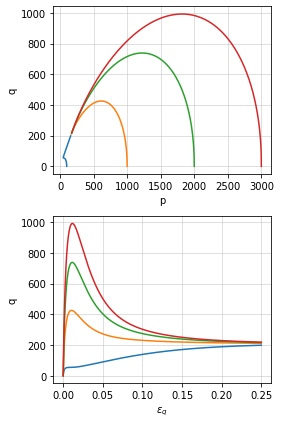

In [6]:
G0 = 125
nu = 0.05
M = 1.25
c = 0.712
lambda_c = 0.019
e0 = 0.934
e = 0.907
xi = 0.7
m = 0.01
h0 = 7.05
ch = 0.968
nb = 1.1
A0 = 0.704
nd = 3.5
zmax = 4.0
cz = 600
pa = 101.325
z = 0.0
p0 = [100, 1000, 2000, 3000]
q0 = [0, 0, 0, 0]
N = 10000
epsilon_q = np.linspace(0,0.25,N)
epsilon_v = np.zeros(N)
q = []
p = []
for i in range(len(p0)):
    q_temp, p_temp = dafalias_manzari_strain_control(G0,nu,M,c,lambda_c,e0,e,xi,m,h0,ch,nb,A0,nd,zmax,cz,pa,z,p0[i],q0[i],epsilon_q,epsilon_v)
    q.append(q_temp)
    p.append(p_temp)
    
fig, ax = plt.subplots(nrows=2,figsize=(4,6))
for i in range(len(p0)):
    ax[0].plot(p[i],q[i])
    ax[1].plot(epsilon_q,q[i])
ax[0].grid(True,alpha=0.5)
ax[1].grid(True,alpha=0.5)
ax[0].set_xlabel('p')
ax[0].set_ylabel('q')
ax[1].set_xlabel(r'$\varepsilon_q$')
ax[1].set_ylabel('q')
plt.tight_layout()

# Strain controlled cyclic undrained

Text(4.0, 0.5, 'q')

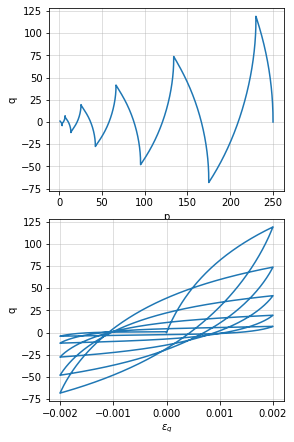

In [7]:
G0 = 125
nu = 0.05
M = 1.25
c = 0.712
lambda_c = 0.019
e0 = 0.934
e = 0.833
xi = 0.7
m = 0.01
h0 = 7.05
ch = 0.968
nb = 1.1
A0 = 0.704
nd = 3.5
zmax = 4.0
cz = 600
pa = 101.325
z = 0.0
p0 = 250
q0 = 0
N = 999
Ncyc = 5
time = np.linspace(0,Ncyc*N,Ncyc*N)
epsilon_q = 0.002*np.sin(2.0*np.pi/N*time)
#epsilon_q = np.linspace(0,0.25,N)
epsilon_v = np.zeros(N*Ncyc)

q, p = dafalias_manzari_strain_control(G0,nu,M,c,lambda_c,e0,e,xi,m,h0,ch,nb,A0,nd,zmax,cz,pa,z,p0,q0,epsilon_q,epsilon_v)

    
fig, ax = plt.subplots(nrows=2,figsize=(4,6))
ax[0].plot(p,q)
ax[1].plot(epsilon_q,q)
ax[0].grid(True,alpha=0.5)
ax[1].grid(True,alpha=0.5)
fig.tight_layout()
ax[0].set_xlabel('p')
ax[0].set_ylabel('q')
ax[1].set_xlabel(r'$\varepsilon_q$')
ax[1].set_ylabel('q')

# Stress-Controlled Undrained Cyclic Loading


In [8]:
def dafalias_manzari_stress_control(G0,nu,M,c,lambda_c,e0,e,xi,m,h0,ch,nb,A0,nd,zmax,cz,pa,z,p0,q,epsilon_q0,epsilon_v):
    N = len(q)
    # Initialize arrays to 0
    p = np.zeros(N)
    epsilon_q = np.zeros(N)
    p[0] = p0
    epsilon_q[0] = epsilon_q0
    G = G0*pa*(2.97-e)**2/(1+e)*(p[0]/pa)**0.5
    K = 2*(1+nu)/(3*(1-2*nu))
    #eta = q[0]/p[0]
    depsilon_qp = 0.0
    depsilon_vp = 0.0
    eta_in = m*np.sign(epsilon_q[1] - epsilon_q[0])
    alpha = 0.0
    SIGN = 0
    d = 0
    H = math.inf
    for i in range(1,N,1):
        dq = q[i] - q[i-1]
        G = G0*pa*(2.97-e)**2/(1+e)*(p[i-1]/pa)**0.5
        K = 2*(1+nu)/(3*(1-2*nu))*G
        depsilon_qe = dq/(3*G)
        depsilon_v = epsilon_v[i] - epsilon_v[i-1]
        q_trial = q[i]
        p_trial = p[i-1] + K*depsilon_v
        alpha_trial = alpha
        s = np.sign(q_trial - p_trial*alpha_trial)
        f_trial = q_trial*s - p_trial*(alpha_trial*s + m)
        if(f_trial<0):
            depsilon_qp = 0.0
            epsilon_q[i] = epsilon_q[i-1] + depsilon_qe
            depsilon_vp = 0.0
            p[i] = p_trial
            q[i] = q_trial
            H = math.inf
        else:
            if(H == math.inf):
                dgamma = 0.0
            else:
                a = K*d*s*H
                b = K*d*(alpha_trial + m*s) - H*p_trial - 3*G
                c = f_trial
                dgamma = (-b - np.sqrt(b**2-4*a*c))/(2*a)
            depsilon_qp = dgamma*s
            epsilon_q[i] = epsilon_q[i-1] + depsilon_qp + depsilon_qe
            depsilon_vp = d*np.abs(depsilon_qp)
            p[i] = p[i-1] + K*(depsilon_v - depsilon_vp)            
            eta = q[i]/p[i]
            if(s != SIGN):
                eta_in = alpha + m*s
                SIGN = s
            b0 = G0*h0*(1-ch*e)*(p[i]/pa)**-0.5
            if(eta==eta_in):
                depsilon_qp = 0.0
                depsilon_vp = 0.0
                continue
            h = b0/np.abs(eta-eta_in)
            psi = e - (e0 - lambda_c*(p[i]/pa)**xi)
            Mb = M*np.exp(-nb*psi)
            Md = M*np.exp(nd*psi)
            H = h*(Mb - eta*s)       
            alpha = alpha + H*depsilon_qp
            if(-depsilon_vp>0):
                dz = cz*depsilon_vp*(s*zmax + z)
            else:
                dz = 0
            z = z+dz
            if(s*z>0):
                Ad = A0*(1+s*z)
            else:
                Ad = A0
            d = Ad*(Md - eta*s)
        e = e - depsilon_v*(1+e)
    return([epsilon_q,p])

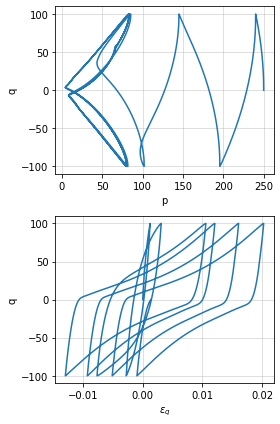

In [9]:
G0 = 125
nu = 0.05
M = 1.25
c = 0.712
lambda_c = 0.019
e0 = 0.934
e = 0.8
xi = 0.7
m = 0.01
h0 = 7.05
ch = 0.968
nb = 1.1
A0 = 0.704
nd = 3.5
zmax = 5.0
cz = 600
pa = 101.325
z = 0.0
p0 = 250
q0 = 0
N = 1000
Ncyc = 6
time = np.linspace(0,Ncyc*N,Ncyc*N)
epsilon_q0 = 0.0
q = 0.4*p0*np.sin(2.0*np.pi/N*time)
#epsilon_q = np.linspace(0,0.25,N)
epsilon_v = np.zeros(N*Ncyc)

epsilon_q, p = dafalias_manzari_stress_control(G0,nu,M,c,lambda_c,e0,e,xi,m,h0,ch,nb,A0,nd,zmax,cz,pa,z,p0,q,epsilon_q0,epsilon_v)
    
fig, ax = plt.subplots(nrows=2,figsize=(4,6))
ax[0].plot(p,q)
ax[1].plot(epsilon_q,q)
ax[0].grid(True,alpha=0.5)
ax[1].grid(True,alpha=0.5)
ax[0].set_xlabel('p')
ax[0].set_ylabel('q')
ax[1].set_xlabel(r'$\varepsilon_q$')
ax[1].set_ylabel('q')
plt.tight_layout()